# 14장 합성곱 신경망을 사용한 컴퓨터 비전

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')/255
flower = load_sample_image('flower.jpg')/255

In [3]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

##14.2 합성곱 층

In [4]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

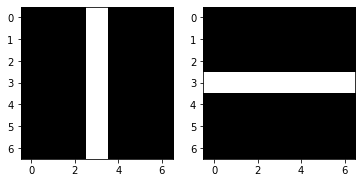

In [5]:
plt.figure(1)
plt.subplot(1, 2, 1)
plt.imshow(filters[:, :, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(filters[:, :, :, 1])
plt.show()

In [6]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

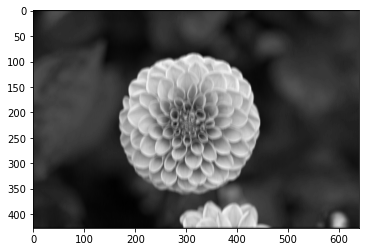

In [7]:
# plt.figure(figsize=(15, 10))
plt.imshow(outputs[1, :, :, 0], cmap='gray')
plt.show()

##14.3 풀링 층

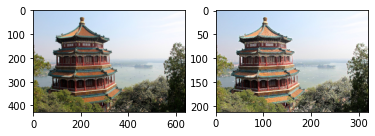

In [8]:
# pool_outputs = tf.nn.avg_pool2d(images, ksize=2, strides=2, padding='VALID')
pool_outputs = tf.nn.max_pool2d(images, ksize=2, strides=2, padding='VALID')
plt.subplot(1, 2, 1)
plt.imshow(images[0, :, :, :])
plt.subplot(1, 2, 2)
plt.imshow(pool_outputs[0, :, :, :])
plt.show()

##14.4 CNN 구조

In [9]:
model = keras.models.Sequential([
            keras.layers.Conv2D(64, 7, activation="relu", padding="same", 
                                    input_shape=[28, 28, 1]),
            keras.layers.MaxPool2D(2),
            keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
            keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
            keras.layers.MaxPool2D(2),
            keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
            keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
            keras.layers.MaxPool2D(2),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(.5),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(.5),
            keras.layers.Dense(10, activation="softmax")

])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [11]:
lenet = keras.models.Sequential([
                            keras.layers.InputLayer([32, 32, 3]),
                            keras.layers.Conv2D(filters=6, kernel_size=5, 
                                                strides=1, activation='tanh'),
                            keras.layers.MaxPool2D(pool_size=2, strides=2),
                            keras.layers.Activation('tanh'),

                            keras.layers.Conv2D(filters=10, kernel_size=5, 
                                                strides=1, activation='tanh'),
                            keras.layers.MaxPool2D(pool_size=2, strides=2),
                            keras.layers.Activation('tanh'),

                            keras.layers.Conv2D(filters=120, kernel_size=5, 
                                                strides=1, activation='tanh'),
                            keras.layers.Flatten(),
                            keras.layers.Dense(84, activation='tanh'),
                            keras.layers.Dense(10, activation='softmax')
])

In [12]:
lenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 10)        1510      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 5, 5, 10)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 120)        

##14.5 케라스를 사용해 ResNet-34 CNN 구현하기

In [13]:
# Conv2D Example
# Input(batch_size, width, height, channels)
B, W, H, C = 2, 11, 11, 2
X = tf.Variable(np.ones(B*W*H*C, dtype=np.float32))
X = tf.reshape(X,(B, W, H, C))
# Conv2D Layer
# Hyper params
strides, filters, kernel, padding = 2, 3, 3, 'same'
conv_layer = keras.layers.Conv2D(filters, kernel, strides, padding=padding)
# Operation
# (input.shape, output.shape, kernel.shape)
X.shape, conv_layer(X).shape, conv_layer.weights[0].shape

(TensorShape([2, 11, 11, 2]),
 TensorShape([2, 6, 6, 3]),
 TensorShape([3, 3, 2, 3]))

In [14]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
                        keras.layers.Conv2D(filters, 3, strides=strides,
                                            padding='same', use_bias=False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters, 3, strides=1,
                                            padding='same', use_bias=False),
                        keras.layers.BatchNormalization()]
        # stides가 1이 아니면 input과 output의 shape이 다르므로 연산이 안된다.
        # skip_layers층을 통과하여 shape을 맞춘다.
        if strides == 1:
            self.skip_layers = []
        else:
            self.skip_layers = [
                            # padding값이 'same'일 경우 kernel size는 
                            # output shape에 영향을 주지 않는다.
                            # (필요한 만큼 padding을 생성하기때문!)
                            keras.layers.Conv2D(filters, 1, strides=strides,
                                                padding='same', use_bias=False),
                            keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs 
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [15]:
# assert keras.models.Sequential == keras.Sequential
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if prev_filters == filters else 2
    model.add(ResidualUnit(filters, strides=strides)) 
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

##14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

In [17]:
from keras.applications import resnet50

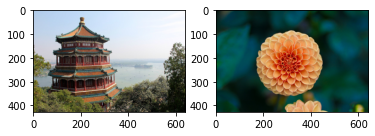

In [18]:
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(images[1])
plt.show()

####tf.keras.applications.resnet50.ResNet50

In [19]:
model = resnet50.ResNet50()

102973440/102967424 [==============================] - 2s 0us/step


####tf.image.crop_and_resize

####tf.image.resize

In [20]:
images_resized = tf.image.resize(images, [224, 224])

####tf.keras.applications.resnet50.preprocess_input

In [21]:
inputs = resnet50.preprocess_input(images_resized * 255)

In [22]:
y_proba = model.predict(inputs)

####tf.keras.applications.resnet50.decode_predictions

In [23]:
top_K = resnet50.decode_predictions(y_proba, top=3)

40960/35363 [==================================] - 0s 0us/step


In [24]:
top_K

[[('n02825657', 'bell_cote', 0.82348686),
  ('n03877845', 'palace', 0.06751674),
  ('n03781244', 'monastery', 0.04188349)],
 [('n03530642', 'honeycomb', 0.4982827),
  ('n13040303', 'stinkhorn', 0.33955017),
  ('n02206856', 'bee', 0.043463744)]]

##14.7 사전훈련된 모델을 사용한 전이 학습

In [25]:
import tensorflow_datasets as tfds

In [ ]:
dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [55]:
dataset_size = info.splits['train'].num_examples # 3670

In [56]:
class_names = info.features['label'].names
# ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [57]:
n_classes = info.features['label'].num_classes # 5

5

In [36]:
info.splits['train'].num_examples

3670

### data split

###tfds.load

In [60]:
# tfds.Split.TRAIN.subsplit은 지원 종료
train_set, valid_set, test_set = tfds.load(
    name="tf_flowers", 
    split=('train[:75%]', 'train[75%:90%]', 'train[90%:]'),
    as_supervised=True)

### preprocess

###tf.image.resize

In [61]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [62]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

### trasnfer learning

In [65]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', 
                                                     include_top=False)
                                                     # AvgPool, Dense층 제외
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# model.summary()

###trainable

In [70]:
# base_model 객체 자체를 사용하는 것X -> base_model.trainable=False 효과X
for layer in base_model.layers:
    layer.trainable = False

In [82]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# GPU 학습
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 589s 7s/step - loss: 1.3395 - accuracy: 0.7983 - val_loss: 0.6046 - val_accuracy: 0.8857
Epoch 2/5
86/86 [==============================] - 582s 7s/step - loss: 0.4144 - accuracy: 0.9081 - val_loss: 0.5410 - val_accuracy: 0.8838
Epoch 3/5
86/86 [==============================] - 583s 7s/step - loss: 0.1831 - accuracy: 0.9448 - val_loss: 0.4170 - val_accuracy: 0.8911
Epoch 4/5
86/86 [==============================] - 582s 7s/step - loss: 0.1141 - accuracy: 0.9611 - val_loss: 0.4084 - val_accuracy: 0.8911
Epoch 5/5
18/86 [=====>........................] - ETA: 6:28 - loss: 0.0670 - accuracy: 0.9826

In [ ]:
# 동결해제
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# 학습률 수정: 사전 훈련된 가중치 보존
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
63/86 [====================>.........] - ETA: 2:10 - loss: 1.4336 - accuracy: 0.7817

##14.8 분류와 위치 추정